<a href="https://colab.research.google.com/github/pakrentos/eeg_connectivity/blob/master/RedArticle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import scipy as sp
import random
from scipy.integrate import solve_ivp as ivp
from scipy.signal import butter, lfilter
from matplotlib import pyplot as plt
from os.path import join
import time
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import keras.metrics as metrics
from sklearn import preprocessing
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import math
import os
from sklearn.model_selection import ShuffleSplit
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

Метрики

In [ ]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
def normalize(arr:np.array):
    return (arr - arr.min())/(arr.max()-arr.min())

Осциллятор Рёсслера

In [ ]:
a = 0.15
p = 0.2
c = 10
fps = 150
start_time = 0
end_time = 40
omega = np.array([0.99, 0.95])
epsylon = np.array([0, 0.03])
idx = []
for i in range(0, fps):
    idx.append(i)

In [ ]:
"""
Indeces
X1 = 0
Y1 = 1
Z1 = 2
X2 = 3
Y2 = 4
Z2 = 5
"""
def rossler(t, vec: np.array):
    res = np.zeros(6)
    x = vec[0:4:3]
    y = vec[1:5:3]
    z = vec[2:6:3]
    res[0:4:3] = -omega*y - z + epsylon*(x[::-1] - x)
    res[1:5:3] = omega*x + a*y
    res[2:6:3] = p + z*(x-c)
    return res

In [ ]:
time=np.linspace(start_time, end_time, num=int(fps*end_time))
z0 = np.zeros(6)
res = ivp(rossler, (start_time,end_time), z0, t_eval=time)
data = res['y']
time = res['t']
data = data.T

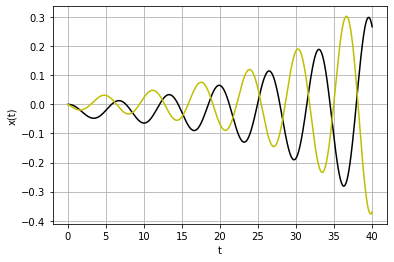

In [ ]:
t = 40
plt.plot(time[0:fps*t], data[0:fps*t, 4], 'k', label='Dependent system 2')
plt.plot(time[0:fps*t], data[0:fps*t, 0], 'y', label='Independent system 1')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.grid()
plt.show()

Модели

In [ ]:
num_epochs = 40


In [ ]:
#Создание модели
def baseline_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(3, activation='linear'))
    model.add(layers.Dense(10,  kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5), activation='tanh'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5), activation='tanh'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(3, activation='linear'))
    #Компиляция модели
    model.compile(loss='mse', optimizer=tf.optimizers.Adam(0.001), metrics=[coeff_determination, 'accuracy'])
    return model

In [ ]:
model_dir = 'D:\\Jupyterlabs\\Assignment\\saved_models\\best_model.h5'

In [ ]:
my_callbacks = [
#     tf.keras.callbacks.EarlyStopping(monitor= , mode='min', patience=10),
    tf.keras.callbacks.EarlyStopping(patience=10, min_delta=0.001, restore_best_weights=False)
]

In [ ]:
rsq = []
hist = []

for i in range(0, end_time-start_time):
    src_init  = data[(start_time+i)*fps:(start_time+i+1)*fps, 0:3]
    trgt_init = data[(start_time+i)*fps:(start_time+i+1)*fps, 3:6]
    random.seed()
    split_idx = random.sample(idx, int(fps/2))
    "Generating test and validation sets"
    val_src = np.delete(src_init, split_idx, axis=0)
    val_trgt = np.delete(trgt_init, split_idx, axis = 0)
    model = baseline_model()
    history = model.fit(src_init[split_idx, 0:3], trgt_init[split_idx, 0:3],
                        epochs=num_epochs, callbacks=my_callbacks, validation_data=(val_src, val_trgt),
                        verbose=0)
    rsq.append(history.history['val_coeff_determination'][-1])
    hist.append(history)

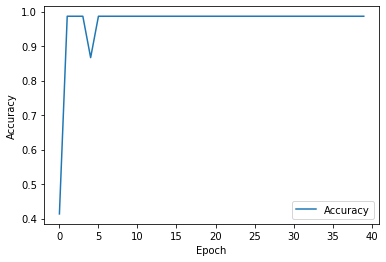

In [ ]:
df = pd.DataFrame(hist[0].history)
df['epoch'] = hist[0].epoch
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(df['epoch'], df['accuracy'],
        label = 'Accuracy')
plt.legend()
plt.show()

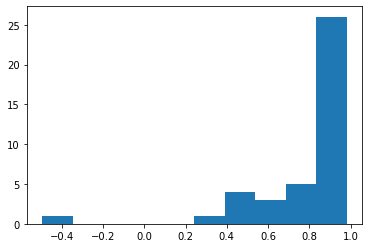

In [ ]:
plt.figure()
plt.hist(rsq)
plt.show()

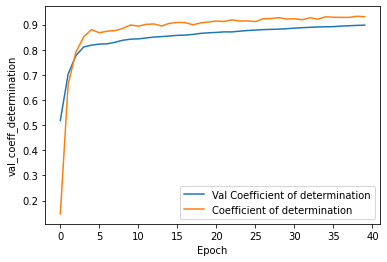

In [ ]:
plot_history2(hist[8])

In [ ]:
### Данные, которые мы предсказываем
a = range(0, 250)
plt.figure()
plt.plot(a, trgt_predict1[:, :], label='source')
plt.plot(a, res, label='prediciton')
plt.xlabel('t')
plt.ylabel('X')
plt.legend()
plt.show()

NameError: name 'trgt_predict1' is not defined

<Figure size 432x288 with 0 Axes>

NameError: name 'trgt_predict1' is not defined

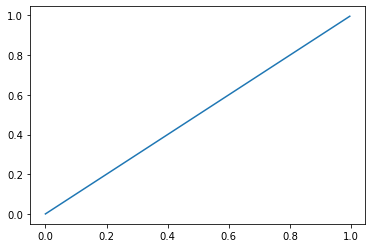

In [ ]:
### Данные, которые мы предсказываем
a=[]
for i in range(0, 250):
    a.append(i/250)
plt.figure()
plt.plot(a, a, label='best_case')
plt.scatter(trgt_predict1[:, :], res, label='y, y_hat', color='r')
plt.xlabel('t')
plt.ylabel('X')
plt.legend()
plt.show()

In [ ]:
a = pd.DataFrame(hist[0].history)
a.describe()

,loss,coeff_determination,val_loss,val_coeff_determination
count,11.000000,11.000000,11.000000,11.000000
mean,0.001058,-6.248511,0.000525,-3.066294
std,0.001864,12.212457,0.000563,4.361237
min,0.000068,-41.982334,0.000036,-13.644909
25%,0.000196,-6.366912,0.000179,-4.521418
50%,0.000333,-1.598383,0.000255,-1.015622
75%,0.000957,-0.341646,0.000729,-0.463237
max,0.006532,0.399054,0.001871,0.710901


In [ ]:
###ADDED
### Рисует график обучения (loss function) и график метрики (coeff_determination). Своровано и адаптировано отсюда: https://www.tensorflow.org/tutorials/keras/regression?hl=ru
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
           label = 'Loss function')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'val_loss')
    plt.legend()
    plt.show()


In [ ]:
def plot_history2(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('val_coeff_determination')
    plt.plot(hist['epoch'], hist['val_coeff_determination'],
           label='Val Coefficient of determination')
    plt.plot(hist['epoch'], hist['coeff_determination'],
           label='Coefficient of determination')
    plt.legend()
    plt.show()


In [ ]:
hist = pd.DataFrame(histories.history)
hist.describe()

,loss,coeff_determination,val_loss,val_coeff_determination
count,59.000000,59.000000,59.000000,59.000000
mean,0.060478,0.248469,0.050367,0.116094
std,0.027811,0.349558,0.009238,0.210823
min,0.054922,-2.325356,0.047261,-1.043058
25%,0.054974,0.304638,0.047719,0.162720
50%,0.055034,0.316433,0.047944,0.171764
75%,0.055332,0.320760,0.048333,0.176654
max,0.264994,0.328304,0.101204,0.186966
